/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'70 years performance data of major asset classes'}, xlabel='year', ylabel='index points'>

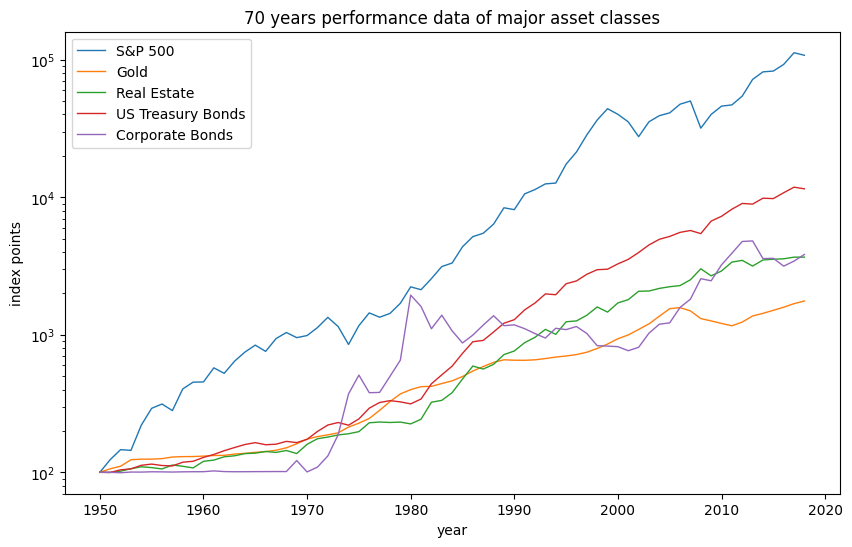

In [2]:
# to run code type:
# pyenv shell 3.9.1
# pipenv shell

import pandas as pd

raw_data = pd.read_csv('data.csv')
columns_selection = ["Year", "S&P 500 (includes dividends)", 'US T. Bond', 'Real Estate','Inflation Rate', "Baa Corporate Bond"]
ts_selection = ["Year", "S&P 500 (includes dividends)3",'Real Estate2', 'US T. Bond5', "Baa Corporate Bond6" ]
raw = raw_data[ts_selection]

# prepare data for plotting
for c in ts_selection[1:]:
    raw[c] = raw[c].apply(lambda x: float(x[1:].replace(",","")))
raw = raw[[int(year) < 2019 and int(year) > 1949 for year in raw["Year"]]]


# prepare training data
data = raw_data[columns_selection]
for c in columns_selection[1:]:
    data[c] = data[c].apply(lambda x: float(x[:-1])/100 + 1)
data = data[[int(year) < 2019 and int(year) > 1949 for year in data["Year"]]]


gold = pd.read_csv("monthly.csv")
is_january = [x[-2:] == "01" for x in gold["Date"].values]

# is_january = gold[[date[:-2:] == "01" for date in gold["Date"].values]]
# gold = gold[is_january]
#gold
gold = gold[is_january]
data["gold"] = gold["Price"].values

data["gold"] = data["gold"].pct_change()
data["gold"] = data["gold"].apply(lambda x: x + 1)

#prepare plotting data
ts_selection.append("gold")
raw["gold"] = gold["Price"].values
for c in ts_selection[1:]:
    raw[c] = 100 / raw[c].values[0] * raw[c] 

raw_renamed = raw.copy()
raw_renamed.columns = ["Year","S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ]
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), logy=True, xlabel="year", ylabel="index points",  title="70 years performance data of major asset classes")

#print(gold.head(3))
#print(data.head(10)
#data.columns

<AxesSubplot:title={'center':'70 years performance data of major asset classes'}, xlabel='year', ylabel='index points'>

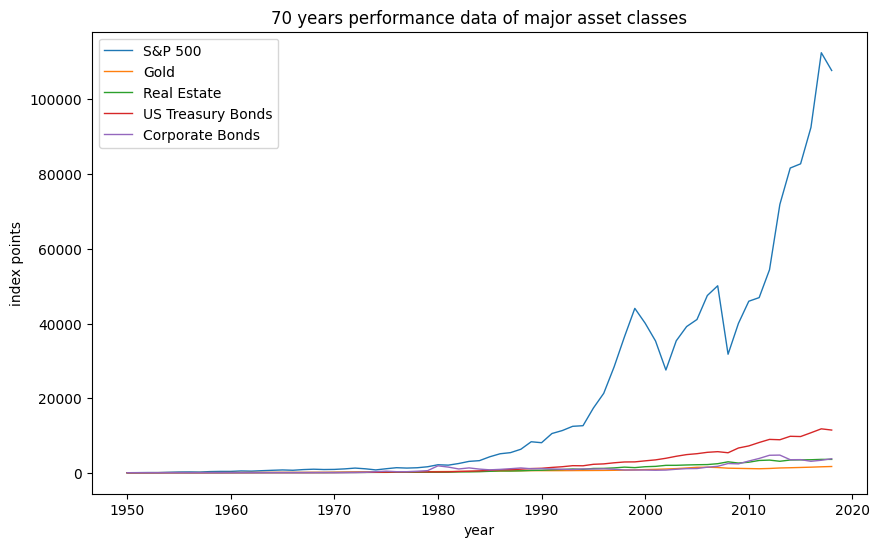

In [75]:
raw_renamed.plot("Year", ["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds', "Corporate Bonds" ], linewidth=1.0, figsize= (10,6), xlabel="year", ylabel="index points", title="70 years performance data of major asset classes")


In [4]:
import gym
from gym import spaces
import numpy as np
import math

class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}
    def __init__(self, data, rebalancing=False):
        super(CustomEnv, self).__init__()
        self.data = data
        self.rebalancing = rebalancing
        self.reward_range = (-np.inf, np.inf) 
        # Define action and observation space
        # They must be gym.spaces objects
        # Space of possible actions:
        self.action_space = spaces.Box(low=0.001, high=100, shape=(4,))
        # Example for using image as input (channel-first; channel-last also works):

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(57, ), dtype=np.float16)
    
    def get_obs_sample(self):
        return self.observation_space.sample()

    def get_random_preferences(self):
      return np.array([np.random.randint(0,10), np.random.randInt(0,100)],dtype=np.float32)

    def set_current_observation(self, observation):
      self.current_observation = observation

    def get_current_observation(self):
      self.current_point_in_time = np.random.randint(11,57)
      self.risk_preference = np.random.randint(0,100)   
      self.horizon_preference = np.random.randint(5,10)
      self.current_asset_data = np.array(self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time - 10: self.current_point_in_time].values,dtype=np.float32)
      self.std_devs = []
      for c in ["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]:
        #print(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
        self.std_devs.append(self.data[[c]].iloc[self.current_point_in_time - 10: self.current_point_in_time].std().values[0])
      
      self.std_devs = np.array(self.std_devs,dtype=np.float32 )
      #print(self.std_devs)
      self.current_observation =  np.concatenate((
        self.current_asset_data.flatten(),
        np.array([self.risk_preference, self.horizon_preference],dtype=np.float32),
        self.std_devs),
        axis=None
        )
      #print("current observation {}".format(self.current_observation))
      return self.current_observation


    def reset(self):
      self.current_step = 0
      #self.action= np.array([50,50],dtype=np.float32)
      return self.get_current_observation()

    
    def _next_observation(self):
      self.current_step += 1
      #print("Current Step: {}".format(self.current_step))
      return self.get_current_observation()

    def _calculate_reward(self, action, *args, **kwargs):
      #relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      #print("Action {}".format(action))
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      
      action_sum = action.sum()
      asset_allocation = [action[0]/action_sum, action[1]/action_sum, action[2]/action_sum, action[3]/action_sum]
      
      if self.rebalancing:
        aggregated_timeseries = []
        i = 0
        for step in relevant_timeseries.iterrows():
          if i == 0:
          # calculate asset allocation after step
            aggregated_timeseries.append(
              asset_allocation[i] * step[1].values
            ) 
            i += 1
          else:
            resulting_allocation = [aggregated_timeseries[-1][i] / np.array(aggregated_timeseries[-1]).sum() for i in [0,1,2,3]]
          
            
            if abs(max(([(resulting_allocation[i] - asset_allocation[i])/asset_allocation[i] for i in [0,1,2,3]]), key=abs)) > self.rebalancing:
              print("rebalancing necessary!")
              # do rebalacing


              current_portfolio_value = np.array(aggregated_timeseries[-1]).sum()
              rebalanced_portfolio = [asset_allocation[i] * current_portfolio_value for i in [0,1,2,3]]
            
            
          
              aggregated_timeseries.append(
                rebalanced_portfolio * (step[1].values)
              ) 
            else:
              # weiterlaufen lassen
              aggregated_timeseries.append(
                aggregated_timeseries[-1] * (step[1].values)
              ) 
            print("looking for correction: \n resulting: {} \n aimed: {}".format(resulting_allocation,asset_allocation))
            print("delta: {}\n current timeseries: {}".format(step[1].values, aggregated_timeseries[-1]))
          
      else:
        aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"]-1) \
        +((action[1] / action.sum())*(relevant_timeseries["gold"]-1)) \
          + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"]-1)) \
            + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"]-1)) 
      
      #reward = list(aggregated_timeseries.cumprod())[-1] - self.risk_preference * aggregated_timeseries.std() / 15 #16
      if (self.risk_preference * np.array(aggregated_timeseries).std()) != 0:
        reward = list(np.array(aggregated_timeseries).cumprod())[-1] - ((self.risk_preference) * np.array(aggregated_timeseries).std() / 16)
      else:
        reward = 0
      if reward == np.nan or math.isinf(reward):
        reward = 0
      else:
        #print(reward)
        return reward

    def calculate_revenue(self, action, *args, **kwargs):
      relevant_timeseries = self.data[["S&P 500 (includes dividends)", "gold", "Real Estate", "US T. Bond", "Baa Corporate Bond"]].iloc[self.current_point_in_time: self.current_point_in_time + self.horizon_preference]
      #print("Action {}".format(action))
     
      aggregated_timeseries = 1 + (action[0] / action.sum())*(relevant_timeseries["S&P 500 (includes dividends)"]-1) \
      +((action[1] / action.sum())*(relevant_timeseries["gold"]-1)) \
         + ((action[2] / action.sum())*(relevant_timeseries["Real Estate"]-1)) \
          + ((action[3] / action.sum())*(relevant_timeseries["US T. Bond"]-1)) 
      
      reward = list(aggregated_timeseries.cumprod())[-1]
      
      if reward == np.nan or math.isinf(reward):
        return 0
      else:
        return reward


    def step(self, action):
      #self._take_action(action)
     
      self.reward = self._calculate_reward(action)
      return self._next_observation(), self.reward, self.current_step < 1500, {}

    # def reset(self):
    #     pass
		# #return observation  # reward, done, info can't be included
    def render(self, mode='human'):
      pass
      #print("The reward is {}".format(self.reward))
      #print(self.reward)

    # def close (self):
    #     pass2


class CustomEnvDisc(CustomEnv):
  def __init__(self, data):
        #super(CustomEnvDisc, self).__init__()
        self.data = data
        self.reward_range = (-np.inf, np.inf) 
        self.action_space = spaces.MultiDiscrete(np.array([100,100,100,100]), dtype=int)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(57, ), dtype=np.float16)
        #print("action space shape is {}".format(self.action_space.shape))
        

In [5]:
# test environment
testEnv = CustomEnv(data, rebalancing=0.2)
testEnv.get_current_observation()
testEnv._calculate_reward(np.array([1,1,1,1]))


looking for correction: 
 resulting: [0.2616055860388222, 0.24818741361194713, 0.2387477349736196, 0.2514592653756111] 
 aimed: [0.25, 0.25, 0.25, 0.25]
delta: [1.1876     1.20523925 1.0298     1.0282    ]
 current timeseries: [0.33911918 0.32650375 0.26836588 0.2822152 ]
looking for correction: 
 resulting: [0.2788341256769685, 0.2684613335125989, 0.22065860595478634, 0.2320459348556463] 
 aimed: [0.25, 0.25, 0.25, 0.25]
delta: [0.8569     1.42697195 1.0342     1.0366    ]
 current timeseries: [0.29059123 0.46591169 0.27754399 0.29254427]
rebalancing necessary!
looking for correction: 
 resulting: [0.21905107564919646, 0.35120970098557225, 0.20921591887745447, 0.22052330448777682] 
 aimed: [0.25, 0.25, 0.25, 0.25]
delta: [0.741      1.98115989 1.1007     1.0199    ]
 current timeseries: [0.24575102 0.65704731 0.36504473 0.33824759]
rebalancing necessary!
looking for correction: 
 resulting: [0.1530119223744093, 0.4090972779128074, 0.2272877502800436, 0.2106030494327396] 
 aimed: [0.25

-0.7319625941562422

In [6]:
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, MlpLnLstmPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines import PPO1
from stable_baselines3 import A2C, DDPG, SAC, TD3

#np.array([1,2,3])[-1]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."
/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
file_name = "validation_set.csv"
test_env = CustomEnv(data)
def create_and_save_val_set(file_name, size=1000):
        data = []
        for i in range(0,1000):
                data.append(env.get_current_observation())
                pd.DataFrame(data).to_csv(file_name)

#create_and_save_val_set(file_name)

val_data = pd.read_csv("./"+file_name)

In [8]:
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from itertools import product

# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=300, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	"A2C": A2C, 
	"PPO1":PPO1,
	"DDPG":DDPG,
	"SAC":SAC,
	"TD3":TD3,
	
	}



#obs = env.get_current_observation()

def calculate_score_on_val(model):
	# obs = env.reset()
	# done = False
	# while not done:
	# 	action, _states = model.predict(obs)
	# 	obs, rewards, done, info = env.step(action)
	# 	env.render()
	actions = []
	for i in val_data.iterrows():
		env.set_current_observation = i[1].values
	
		action = model.predict(env.current_observation, deterministic=True)
		actions.append(action[0])
		try:
			score += env._calculate_reward(action[0])
			revenue += env.calculate_revenue(action[0])
			
			
		except:
			score = 0
			revenue = 0
	#print(actions)
	average_action = np.array(actions).mean(axis=0)
	return score, average_action, revenue, actions

scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
#models = [A2C, PPO, DDPG, SAC, TD3]
learning_rates = [0.01, 0.0001, 0.00001]
batch_sizes = [1, 10, 30]
total_timesteps = 1500

for model, learning_rate, batch_size in product(models, learning_rates, batch_sizes):
	if model == "A2C":
		print(model)
		for use_rms_prop in [True, False]:
			m = models[model]('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = use_rms_prop, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_{}_{}".format(model,str(learning_rate), str(use_rms_prop), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

	if model == "TD3":
		print(model)
		m = models[model]('MlpPolicy',env, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
		scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

	
	if model == "PPO1":
		print(model)
		m = models[model]('MlpPolicy',env,optim_stepsize=learning_rate, optim_batchsize=batch_size, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=None)#eval_callback)
		key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
		scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

	print("{} score is {}".format(key if key else "", scores[key] if key else ""))

for model in ["DDPG", "SAC"]:
	for learning_rate in learning_rates:
		for batch_size in batch_sizes:
			print(model)
			n_actions = env.action_space.shape[-1]
			action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
			m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
			m.learn(total_timesteps=total_timesteps, callback=eval_callback)
			key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
			scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
			print("{} score is {}".format(key, scores[key]))

# calculate benchmark score

A2C


/home/martin/.local/share/virtualenvs/beastfolio-kRTU7gQy/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


A2C_0.01_False_1 score is 1215.2315234711423
A2C
A2C_0.01_False_10 score is 1912.4692896040924
A2C
A2C_0.01_False_30 score is 2587.8529398097485
A2C
A2C_0.0001_False_1 score is 1577.9151667797205
A2C
A2C_0.0001_False_10 score is 1113.208007032904
A2C
A2C_0.0001_False_30 score is 1034.55620592151
A2C
A2C_1e-05_False_1 score is 1153.6881735837771
A2C
A2C_1e-05_False_10 score is 1726.2669658781688
A2C
A2C_1e-05_False_30 score is 1357.5290003112393
PPO1





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
PPO1_0.01_-_1 score is 1666.776723026884
PPO1
PPO1_0.01_-_10 score is 1985.9429212625835
PPO1
PPO1_0.01_-_30 score is 2327.8478099497443
PPO1
PPO1_0.0001_-_1 score is 1860.5950826102433
PPO1
PPO1_0.0001_-_10 score is 1846.2473555252154
PPO1
PPO1_0.0001_-_30 score is 1840.2375739246093
PPO1
PPO1_1e-05_-_1 

Text(0.5, 1.0, 'Benchmark asset allocation')

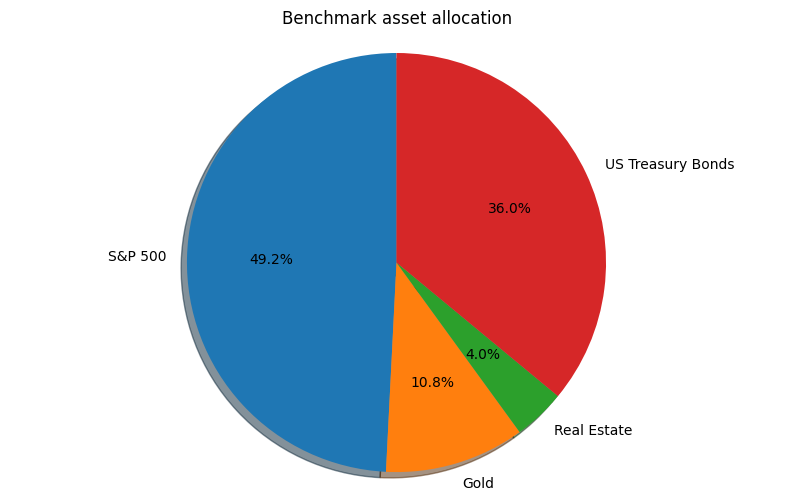

In [9]:
# 11.25 in cash -> gold
# 37.5 in bonds
# 51.25 in stocks
# deduced proportionally for 4 % real estate:
# 10.8 cash, 36 % bonds, 49.2 % stocks -> 4 % real estate
benchmark = np.array([0.492, 0.108, 0.04, 0.36])


import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10,6))

ax1.pie(benchmark, labels=["S&P 500", "Gold",'Real Estate', 'US Treasury Bonds'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
ax1.set_title("Benchmark asset allocation")




		#scores["Benchmark"] += env._calculate_reward(benchmark)
		#print("Benchmark Score is {}".format(scores["Benchmark"]))
#print(scores)
#print(average_actions)
#scores

In [10]:
scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

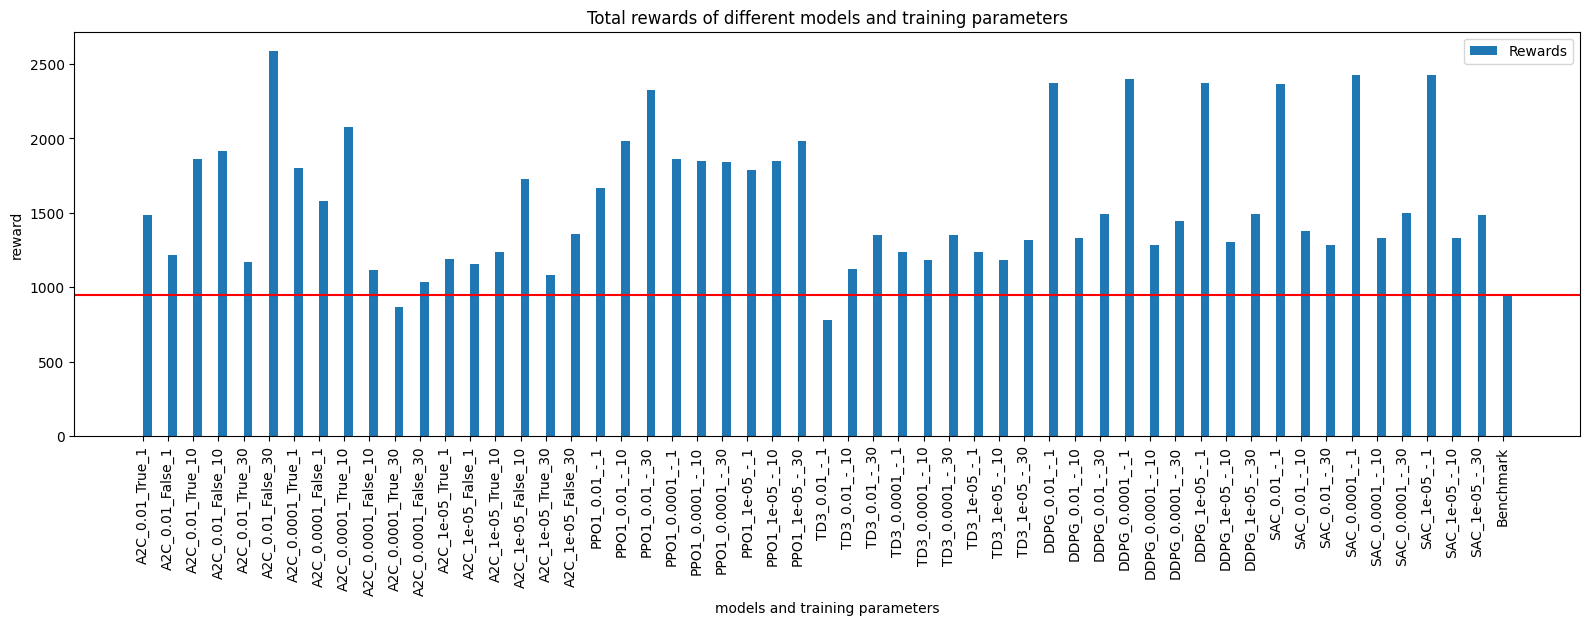

In [11]:



plt.rcParams["figure.figsize"] = (16,5)
fig1, ax1 = plt.subplots()
labels = [k for k in scores]
x = np.arange(len(labels))
#b1 = ax1.bar(x - 0.175 , [revenues[k] for k in revenues], 0.35, label="Revenues")
b2 = ax1.bar(x + 0.175, [scores[k] for k in scores], 0.35, label="Rewards")
ax1.set_xticks(x, labels)
ax1.set_title("Total rewards of different models and training parameters")
# ax1.bar_label(b1, padding=3)
# ax1.bar_label(b2, padding=3)
ax1.set_ylabel("reward")
ax1.set_xlabel("models and training parameters")
fig1.tight_layout()
plt.xticks(rotation='vertical')
plt.axhline(y=scores["Benchmark"], color='r', linestyle='-')
plt.legend()
plt.show()

In [22]:

vals = [scores[s] for s in scores.keys()]
sorted(zip(vals, scores.keys()), reverse=True)
#scores["Benchmark"]

[(2587.8529398097485, 'A2C_0.01_False_30'),
 (2426.276583065341, 'SAC_0.0001_-_1'),
 (2423.702723545809, 'SAC_1e-05_-_1'),
 (2398.6582123956055, 'DDPG_0.0001_-_1'),
 (2373.4480699849214, 'DDPG_1e-05_-_1'),
 (2372.588550009832, 'DDPG_0.01_-_1'),
 (2368.815796650006, 'SAC_0.01_-_1'),
 (2327.8478099497443, 'PPO1_0.01_-_30'),
 (2076.0933775134554, 'A2C_0.0001_True_10'),
 (1985.9429212625835, 'PPO1_0.01_-_10'),
 (1979.9507372233477, 'PPO1_1e-05_-_30'),
 (1912.4692896040924, 'A2C_0.01_False_10'),
 (1860.5950826102433, 'PPO1_0.0001_-_1'),
 (1858.8487929647988, 'A2C_0.01_True_10'),
 (1846.2473555252154, 'PPO1_0.0001_-_10'),
 (1845.494864927808, 'PPO1_1e-05_-_10'),
 (1840.2375739246093, 'PPO1_0.0001_-_30'),
 (1800.7394414220998, 'A2C_0.0001_True_1'),
 (1785.0675225776097, 'PPO1_1e-05_-_1'),
 (1726.2669658781688, 'A2C_1e-05_False_10'),
 (1666.776723026884, 'PPO1_0.01_-_1'),
 (1577.9151667797205, 'A2C_0.0001_False_1'),
 (1498.8318442701438, 'SAC_0.0001_-_30'),
 (1492.8144663389137, 'DDPG_1e-05_-_

In [27]:
# FINE TUNING FOR A2C, SAC, DDPG
# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=1200, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	"A2C": A2C, 
	# "PPO1":PPO1,
	"DDPG":DDPG,
	"SAC":SAC,
	# "TD3":TD3,
	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [0.01, 0.001, 0.0001,0.00001]
batch_sizes = [1, 3, 7, 15, 30]
total_timesteps = 2500

for model, learning_rate, batch_size in product(models, learning_rates, batch_sizes):
	if model == "A2C":
		print(model)
		m = models[model]('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = False, seed=1)
		m.learn(total_timesteps=total_timesteps, callback=eval_callback)
		key = "{}_{}_{}".format(model,str(learning_rate), str(batch_size))
		fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
		print("{} score is {}".format(key if key else "", fine_scores[key] if key else ""))
	# else:
	# 	print(model)
	# 	n_actions = env.action_space.shape[-1]
	# 	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	# 	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	print("{} score is {}".format(key, fine_scores[key]))

	
vals = [fine_scores[s] for s in fine_scores.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#scores["Benchmark"]

fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

	

A2C
A2C_0.01_1 score is 1884.1370993619032
A2C
A2C_0.01_3 score is 1296.4038961326805
A2C
A2C_0.01_7 score is 1770.898309914646
A2C
A2C_0.01_15 score is 1212.6705922979365
A2C
A2C_0.01_30 score is 1090.2183926930786
A2C
A2C_0.001_1 score is 1604.3016512705842
A2C
A2C_0.001_3 score is 1006.5406489663164
A2C
A2C_0.001_7 score is 1382.806757207565
A2C
A2C_0.001_15 score is 1392.2211463145995
A2C
A2C_0.001_30 score is 1004.6284693163392
A2C
A2C_0.0001_1 score is 3956.68857132827
A2C
A2C_0.0001_3 score is 1916.6785000942352
A2C
A2C_0.0001_7 score is 1452.50945439646
A2C
A2C_0.0001_15 score is 1331.9313707640529
A2C
A2C_0.0001_30 score is 1081.3290489293302
A2C
A2C_1e-05_1 score is 1635.7275223306426
A2C
A2C_1e-05_3 score is 1664.679116811185
A2C
A2C_1e-05_7 score is 1186.8957859870484
A2C
A2C_1e-05_15 score is 1273.1231450645512
A2C
A2C_1e-05_30 score is 1112.8637438373237
[(3956.68857132827, 'A2C_0.0001_1'), (1916.6785000942352, 'A2C_0.0001_3'), (1884.1370993619032, 'A2C_0.01_1'), (1770.89

In [32]:
# REBALANCING ON FINE TUNING RESULTS
# Training Environment
env = CustomEnv(data)
eval_env = CustomEnv(data)
# Evaluation Callback (should it be on saparate environment? https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=0)
eval_callback = EvalCallback(eval_env, eval_freq=800, callback_after_eval=stop_train_callback, verbose=0)

# eval_callback = EvalCallback(env, best_model_save_path="./best_models/",
#                              log_path="./best_models/", eval_freq=5000,
#                              deterministic=True, render=False)

env.get_current_observation()
#env = DummyVecEnv([lambda: CustomEnv(data)])

models = {
	"A2C": A2C, 
	# "PPO1":PPO1,
	# "DDPG":DDPG,
	# "SAC":SAC,
	# "TD3":TD3,
	
	}
fine_scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
learning_rates = [0.01, 0.001, 0.0001,0.00001]
batch_sizes = [1, 3, 7, 15, 30]
total_timesteps = 2500

for rebalancing in [False, 5, 10]#, 20, 40]:
	model= "A2C"
	env = CustomEnv(data, rebalancing=rebalancing)
	eval_env = CustomEnv(data, rebalancing=rebalancing)
	print(model)
	m = models[model]('MlpPolicy',env,learning_rate = 0.0001, n_steps=1, use_rms_prop = False, seed=1)
	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	key = "{}_{}_{}_{}".format(model,str(0.0001), str(1), str(rebalancing))
	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	print("{} score is {}".format(key if key else "", fine_scores[key] if key else ""))
	# else:
	# 	print(model)
	# 	n_actions = env.action_space.shape[-1]
	# 	action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
	# 	m = models[model]('MlpPolicy',env, action_noise=action_noise, learning_starts=0, learning_rate=learning_rate, batch_size=batch_size, seed=1)
	# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
	# 	key = "{}_{}_-_{}".format(model,str(learning_rate), str(batch_size))
	# 	fine_scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)
	# 	print("{} score is {}".format(key, fine_scores[key]))

	
vals = [fine_scores[s] for s in fine_scores.keys()]
print(sorted(zip(vals, fine_scores.keys()), reverse=True))
#scores["Benchmark"]

fine_scores["Benchmark"] = 0
revenues["Benchmark"] = 0

for i in val_data.iterrows():
		env.set_current_observation = i[1].values
		try:
			fine_scores["Benchmark"] += env._calculate_reward(benchmark)
			revenues["Benchmark"] += env.calculate_revenue(benchmark)
		except:
			fine_scores["Benchmark"] = 0
			revenues["Benchmark"] = 0

	

SyntaxError: invalid syntax (3994952562.py, line 33)

In [30]:
print(sorted(zip(vals, fine_scores.keys()), reverse=True))

[(2432.6268759511813, 'A2C_0.0001_1_False'), (-0.5622374061716621, 'A2C_0.0001_1_0.05'), (-1.1372064141044371, 'A2C_0.0001_1_0.1'), (-1.6917109402842685, 'A2C_0.0001_1_0.4'), (-1.7963661513910636, 'A2C_0.0001_1_0.2')]


{'A2C_0.01_True_1': 394.5890171342242, 'A2C_0.01_False_1': 191.3821498421755, 'A2C_0.01_True_10': 3286.870246216222, 'A2C_0.01_False_10': 2995.1915018899494, 'A2C_0.01_True_30': 200.71092765508567, 'A2C_0.01_False_30': 391.08768046448654, 'A2C_0.0001_True_1': 3122.898749814417, 'A2C_0.0001_False_1': 2583.527101484596, 'A2C_0.0001_True_10': 3408.7764092520433, 'A2C_0.0001_False_10': 2496.8556283678054, 'A2C_0.0001_True_30': 1276.076547018037, 'A2C_0.0001_False_30': 641.3383473924728, 'A2C_1e-05_True_1': 2040.7925154404277, 'A2C_1e-05_False_1': 2111.495651543374, 'A2C_1e-05_True_10': 2852.2364509791564, 'A2C_1e-05_False_10': 4653.862669298391, 'A2C_1e-05_True_30': 624.1011095293943, 'A2C_1e-05_False_30': 681.480932730333, 'PPO1_0.01_-_1': 2560.2095189066617, 'PPO1_0.01_-_10': 2560.2095189066617, 'PPO1_0.01_-_30': 2560.2095189066617, 'PPO1_0.0001_-_1': 2560.2095189066617, 'PPO1_0.0001_-_10': 2560.2095189066617, 'PPO1_0.0001_-_30': 2560.2095189066617, 'PPO1_1e-05_-_1': 2560.2095189066617, 

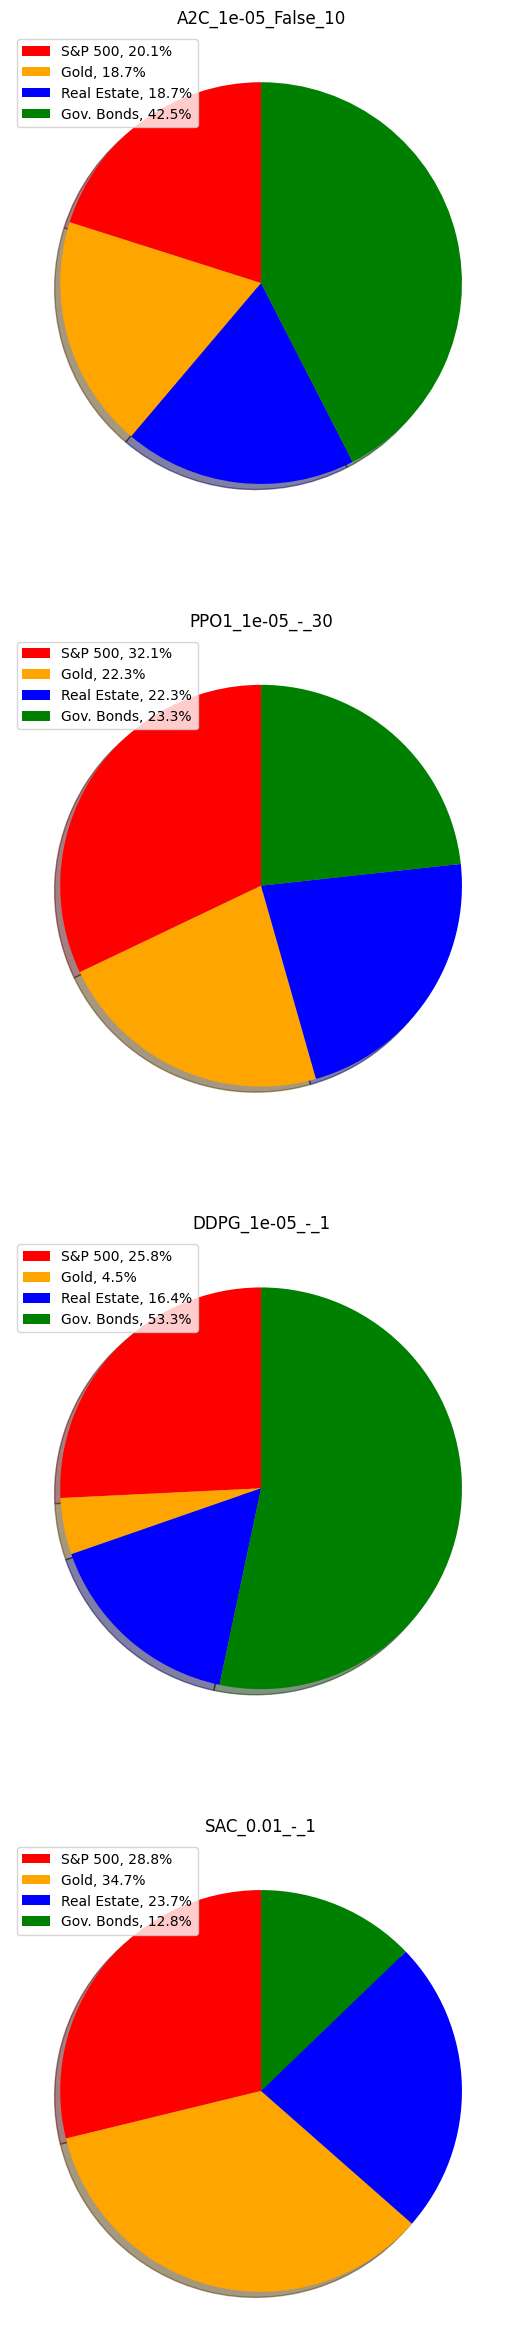

In [191]:

# plot top average strategies
print(scores)
plt.rcParams["figure.figsize"] = (20,30)
labels = ['S&P 500', 'Gold', 'Real Estate', "Gov. Bonds"]
sorted_by_reward = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
fig, axs = plt.subplots(4)
k = 0
m = 0
l=0
for mdl in list(['A2C_1e-05_False_10', 'PPO1_1e-05_-_30', 'DDPG_1e-05_-_1', 'SAC_0.01_-_1', ]):#list(sorted_by_reward.keys())[-3:]:
        #print("Plotting {}".format(mdl))
        axs[m].pie(average_actions[mdl],
                shadow=True, startangle=90, colors=["red", "orange", "blue", "green"])
        lbls = [f'{l}, {(s / average_actions[mdl].sum() * 100):0.1f}%' for l, s in zip(labels, average_actions[mdl])]
        axs[m].legend(lbls, loc='upper left',
           fontsize=10)
        axs[m].title.set_text(mdl)
        m+=1
       
        #print(l)
#plt.legend()

In [12]:
scores = {}
average_actions = {}
revenues = {}
actions = {}
total_score = 0
#models = [A2C, PPO, DDPG, SAC, TD3]
learning_rates = [0.001, 0.00001, 0.0000001]
batch_sizes = [1, 10, 30]
total_timesteps = 10000

# for learning_rate, batch_size, use_rms_prop in product(learning_rates, batch_sizes, [True, False]):
# 	m = A2C('MlpPolicy',env,learning_rate = learning_rate, n_steps=batch_size, use_rms_prop = use_rms_prop, seed=1)
# 	m.learn(total_timesteps=total_timesteps, callback=eval_callback)
# 	key = "{}_{}_{}_{}".format("A2C",str(learning_rate), str(use_rms_prop), str(batch_size))
# 	scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

# for learning_rate in learning_rates:
# 	for batch_size in batch_sizes:
	
stop_train_callback =  StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(eval_env, eval_freq=500, callback_after_eval=stop_train_callback, verbose=1)
n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.01 * np.ones(n_actions))
m = SAC('MlpPolicy',env, learning_rate=0.00001, batch_size=3, seed=1)
m.learn(total_timesteps=total_timesteps, callback=eval_callback)
key = "{}_{}_-_{}".format("SAC",str(learning_rate), str(batch_size))
scores[key], average_actions[key], revenues[key], actions[key] = calculate_score_on_val(m)

scores

0.9934561154848086
2.705880546820243
2.1311261474770675
1.0940602824000998
1.8373241055689806
1.6099039901492243
2.2673641583029465
1.0848065075271582
1.8895607374502787
1.4944961681021096
1.386962172335581
1.6497348774672145
1.6261482835796848
1.4724090603706101
2.2958048341154176
2.9437352711323443
2.3218075958138513
1.6034851214784398
1.8549801688019003
2.5435210739908247
1.952508592553407
1.532972358147298
1.3993593825121582
1.6930306155999062
1.3458470158907618
1.8706231516985132
1.7286320939693134
2.578575559993355
1.6996824153731764
1.4847130596863414
1.6454088309309851
1.2552661193741357
1.3656986665714117
1.6965733675263608
1.0845321427235466
2.3930985780134773
1.2748572570800327
1.412712902156752
1.8387493304384601
1.169659558398274
2.580494959897153
1.4584939799653
1.0997535179836666
1.7203471565476942
1.1445520435953627
1.7387970444021346
1.4275731311628916
1.252762058921722
0.9886993671607469
1.5194929157096202
1.0396349909796754
0.7697725256968356
0.8328659684028052
1.306

{'SAC_1e-05_-_30': 1415.1614495431563}

In [84]:
import os.path
import sys
from os import system

import gym
import torch
#import torchsummary
import tensorflow as tf
import onnx
from onnx_tf.backend import prepare


class OnnxablePolicy(torch.nn.Module):
  def __init__(self,  actor):
      super(OnnxablePolicy, self).__init__()
      self.actor = torch.nn.Sequential(actor.latent_pi, actor.mu)

  def forward(self, observation):
      # NOTE: You may have to process (normalize) observation in the correct
      #       way before using this. See `common.preprocessing.preprocess_obs`
      return self.actor(observation)

print('Exporting to ONNX...')
onnxable_model = OnnxablePolicy(m.policy.actor)
m.policy.to("cpu")
m.policy.eval()
print(str(onnxable_model.actor))
# torchsummary.summary(model.policy.actor, input_size=len(dummy_input))
obs = env.observation_space
dummy_input = torch.FloatTensor(obs.sample().reshape(1, -1))

torch.onnx.export(onnxable_model, dummy_input, "mdl.onnx",
                    input_names=['input'],
                    output_names=['output'],
                    opset_version=9, verbose=True)

# print('Loading ONNX and checking...')
# onnx_model = onnx.load("mdl.onnx")
# onnx.checker.check_model(onnx_model)
# print(onnx.helper.printable_graph(onnx_model.graph))

# print('Converting ONNX to TF...')
# tf_rep = prepare(onnx_model)
# tf_rep.export_graph("mdl")

# print('Converting TF to TFLite...')
# converter = tf.lite.TFLiteConverter.from_saved_model("mdl")
# tflite_model = converter.convert()
# with open("mdl.tflite", 'wb') as f:
#     f.write(tflite_model)

AttributeError: module 'tensorflow._api.v1.autograph.experimental' has no attribute 'do_not_convert'

In [50]:
print(val_data.head(1))
# run through observations and calculate rewards...

obs = env.get_current_observation()
res = model.predict(obs)[0]

print(obs)
print(res)



# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['S&P 500', 'Gold', 'Real Estate', "Gov. Bonds"]
sizes = res
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
df = pd.DataFrame({"time":list(range(0,10)),"S&P":obs[0:10].cumprod(), "Gold":obs[10:20].cumprod(), "Real Estate":obs[20:30].cumprod(), "Gov. Bonds":obs[30:40].cumprod()})
df.plot("time", ["S&P", "Gold", "Real Estate", "Gov. Bonds"])

plt.show()
plt.bar(["risk in %", "investment horizon in yrs."], [obs[-2], obs[-1]], )
plt.ylim([0,100])

   Unnamed: 0       0         1      2       3       4      5         6  \
0           0  1.3174  2.971901  1.074  0.9701  0.9668  0.953  0.826904   

       7      8  ...      47      48      49    50   51      52        53  \
0  1.051  1.082  ...  1.0438  1.1769  1.1579  89.0  7.0  0.1237  0.666164   

         54        55        56  
0  0.025472  0.125708  0.097606  

[1 rows x 58 columns]


AttributeError: 'str' object has no attribute 'predict'

In [ ]:
print(total_score)

293.87118901349163


In [ ]:
#obs = env.get_current_observation()
res = model.predict(obs, deterministic=True)[0]

print(obs)
print(res)

[1.1081001e+00 1.0000000e+00 1.0413001e+00 1.0326999e+00 1.0484999e+00
 9.1759998e-01 1.2021319e+00 1.0699000e+00 9.4989997e-01 9.7970003e-01
 1.0355999e+00 8.2632238e-01 1.0822001e+00 1.1675000e+00 1.0565000e+00
 1.1422000e+00 1.0836147e+00 1.0424000e+00 1.0979000e+00 1.1400000e+00
 1.1876000e+00 1.2052393e+00 1.0298001e+00 1.0282000e+00 1.1141000e+00
 8.5689998e-01 1.4269719e+00 1.0342000e+00 1.0366000e+00 1.0432000e+00
 7.4100000e-01 1.9811599e+00 1.1007000e+00 1.0199000e+00 9.5620000e-01
 1.3700000e+00 1.3707519e+00 1.0677000e+00 1.0361000e+00 1.1105000e+00
 1.2383000e+00 7.4461168e-01 1.0818000e+00 1.1598001e+00 1.1975000e+00
 9.3019998e-01 1.0046395e+00 1.1465000e+00 1.0129000e+00 1.0994999e+00
 6.2000000e+01 7.0000000e+00 1.9248354e-01 3.5390696e-01 3.5854682e-02
 6.7851312e-02 7.2930701e-02]
[4.4637837e+00 1.0756592e+00 1.0000000e-03 1.0000000e-03]


In [ ]:


import yfinance as yf

# Lange Aktienhistorie -> GDP Zeitreihen, abweichung etwa 2.3% ?

acwi = yf.Ticker("SPY")

# get stock info
acwi.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,25.456190,25.456190,25.329542,25.438097,1003200,0.0,0
1993-02-01,25.456190,25.619022,25.456190,25.619022,480500,0.0,0
1993-02-02,25.600918,25.691381,25.546641,25.673288,201300,0.0,0
1993-02-03,25.709473,25.962768,25.691380,25.944675,529400,0.0,0
1993-02-04,26.035142,26.107512,25.745661,26.053234,531500,0.0,0
...,...,...,...,...,...,...,...
2022-08-24,412.109985,415.109985,411.390015,413.670013,49177800,0.0,0
2022-08-25,415.239990,419.559998,414.089996,419.510010,50942300,0.0,0
2022-08-26,419.390015,419.959991,405.250000,405.309998,102896000,0.0,0


In [ ]:
#Gold since 2000
acwi = yf.Ticker("GC%3DF")

# get stock info
acwi.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0,0,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,0,0,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0,0,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2,0,0
2000-09-06,274.200012,274.200012,274.200012,274.200012,0,0,0
...,...,...,...,...,...,...,...
2022-08-12,1786.300049,1800.400024,1784.300049,1798.599976,187,0,0
2022-08-15,1799.000000,1799.000000,1774.699951,1781.400024,64,0,0
2022-08-16,1777.400024,1777.400024,1771.400024,1773.199951,308,0,0


In [ ]:
import pandas as pd
import numpy as np
import os
# raw_data = pd.read_csv(os.path.join(os.getcwd(),"../data/flat_table1.csv"), sep="|")
# raw_vintage_data = pd.read_csv(os.path.join(os.getcwd(),"../data/all_vintages1.csv"), sep="|")
# del raw_data["Unnamed: 0"]
# del raw_vintage_data["Unnamed: 0"]

In [ ]:

target_columns_and_group_by = ['preferences_wineloverVsInvestor', 'preferences_takesRisk',
    'preferences_investmentHorizon', 'vintage_id', 'preferences_user_email',]

raw_data = raw_data[raw_data["preferences_email"].isin(["thomas@test.de", "patrick@test.de", "tradi@test.de", "angsthase@test.de", "zocker@test.de", "heinreich@test.de", "weinliebhaber@test.de", "investor@test.de", "kurz@test.de", "lang@test.de"])]
data = raw_data[target_columns_and_group_by].groupby(["vintage_id"]).mean()
vintage_features = raw_vintage_data#.set_index("id")
vintage_features_columns = []
for x in [l for l in vintage_features.columns if "statistics_climate" not in l and "breakdown" not in l]:
    #print(x)
    vintage_features_columns.append(x)
vintage_features_columns.remove("gwsRecord")
vintage_features_columns.remove("wine_winery_subregion")
vintage_features_columns.remove("wine_winery_subregion_id")
vintage_features_columns.remove("wine_winery_region_id")
vintage_features_columns.remove("wine_winery_classification_id")
vintage_features_columns.remove("wine_winery_title")
vintage_features_columns.remove("wine_winery_id")
vintage_features_columns.remove("title")
vintage_features_columns.remove("wine_winery_classification")
vintage_features_columns


vintage_features = raw_data.drop_duplicates()



#vintage_data = raw_vintage_data[feature_column_selection_vintages]
vintage_data = raw_vintage_data[vintage_features_columns]


delete = ["preferences_wineloverVsInvestor", "preferences_takesRisk", "preferences_investmentHorizon" , "preferences_user_email"]
for d in delete:
    try:
        del vintage_features[d]
    except Exception as e:
        print(e)

raw_data.shape



(296, 9)

In [ ]:



new_data = pd.merge(vintage_data.set_index("id"), data, how="left", left_index=True, right_index=True)



In [ ]:


shorter_titles = {
'latestSellPrice750': "price_750",
 'id':"id",
 'lwin11':"lwin11",
 'year':"year",
 "bottleSize_factorForLiterPrices": "bottle",
 'wine_winery_region_titleUnidecoded':"region",
 'wine_winery_region_country_title':"country",
 'wine_winery_production': "production_p_a",
 'wine_winery_location': "location",
 'wine_winery_classification_titleUnidecoded':"clfkt",
 'statistics_appelation_in_top_percentage_value':"in_top_x_perc_of_app",
 'wine_winery_subregion_titleUnidecoded':"subregion",
 'gwsRecord_livexSubindex':"livex_subindex",
 'gwsRecord_livexSubsubindex':"livex_subsubindex",
 'gwsRecord_isLivex1000':"livex1000",
 'gwsRecord_score':"gws",
 'gwsRecord_journalistCount':"journalist_count",
 'gwsRecord_confidenceIndex':"confidence_index"
}

for k in shorter_titles:
    if not k == shorter_titles[k]:
        try:
            new_data[shorter_titles[k]] = new_data[k]
          
            
            del new_data[k]
         
        except: 
            pass
   





In [ ]:
# CLEAN FEATURES
import numpy as np
from datetime import datetime

try:
    del new_data["statistics_appelation_in_top_percentage_appellation"]
except Exception as e:
    print(e)

new_data["gws"] = new_data["gws"].fillna(new_data["gws"].mean())
new_data["in_top_x_perc_of_app"] = new_data["in_top_x_perc_of_app"].fillna(new_data["in_top_x_perc_of_app"].mean())
new_data["price_750"] = new_data["price_750"].fillna(new_data["price_750"].median())
new_data["drinkingMaturityFrom"] = new_data["drinkingMaturityFrom"].fillna(new_data["drinkingMaturityFrom"].median())
new_data["price_per_point"] = new_data["gws"] / new_data["price_750"]
new_data["journalist_count"] = new_data["journalist_count"].fillna(new_data["journalist_count"].median()).astype("float", copy=False)


try:
    new_data["lat"] = new_data["location"].apply(lambda x: x.split("(")[1].split(")")[0].split(" ")[0]).astype("float", copy=False)
    new_data["long"] = new_data["location"].apply(lambda x: x.split("(")[1].split(")")[0].split(" ")[1]).astype("float", copy=False)

    del new_data["location"]
except Exception as e:
    print(e)

dirtfree_data = new_data

dirtfree_data.replace(to_replace=["None"], value=np.nan, inplace=True)

dirtfree_data["year"] = (datetime.now().year) - dirtfree_data["year"]
dirtfree_data["drinkingMaturityFrom"] = (datetime.now().year) - dirtfree_data["drinkingMaturityFrom"]



cat_cols = ["country", "region", "subregion", "clfkt", "livex1000", "livex_subindex", "livex_subsubindex"]

for col in cat_cols:
    dirtfree_data[col] = dirtfree_data[col].astype("category", copy=False)

print(dirtfree_data.head(10))
dirtfree_data.shape


          lwin11  year  drinkingMaturityFrom   alc  \
id                                                   
157  10060452015     7                  -3.0  15.0   
204  10832462019     3                  -3.0  14.5   
205  10097692020     2                  -8.0  14.0   
128  10062052016     6                   0.0  13.5   
159  10060452017     5                  -3.0  14.0   
9    10087882011    11                   2.0  13.5   
199  10826562008    14                  -1.0  12.5   
140  10141632018     4                  -8.0  14.5   
198  13143772011    11                  -1.0  12.5   
124  10123612018     4                  -8.0  13.5   

     preferences_wineloverVsInvestor  preferences_takesRisk  \
id                                                            
157                            100.0                   44.0   
204                             50.0                   54.0   
205                             46.0                   46.0   
128                            100.0

(174, 23)

In [ ]:

dummyfied_data = pd.get_dummies(dirtfree_data, dummy_na=True, drop_first=True)

try:
    dummyfied_data.set_index(dummyfied_data["lwin11"], inplace=True, drop=True)
    del dummyfied_data["lwin11"]
    del dummyfied_data["vintage"]
except Exception:
    print("Index already set to lwin11")



dummyfied_data.head(15)

Index already set to lwin11


,year,drinkingMaturityFrom,alc,preferences_wineloverVsInvestor,preferences_takesRisk,preferences_investmentHorizon,price_750,production_p_a,in_top_x_perc_of_app,gws,...,livex_subsubindex_Southern Rhone 50,livex_subsubindex_nan,livex1000_True,livex1000_nan,confidence_index_A+,confidence_index_B,confidence_index_B+,confidence_index_C,confidence_index_C+,confidence_index_nan
lwin11,,,,,,,,,,,,,,,,,,,,,
10060452015,7,-3.0,15.0,100.0,44.00,9.0,260.50,10000,1.036415,97.040000,...,0,0,1,0,1,0,0,0,0,0
10832462019,3,-3.0,14.5,50.0,54.00,12.5,171.00,30000,6.474685,95.558993,...,0,1,0,1,0,0,0,0,0,1
10097692020,2,-8.0,14.0,46.0,46.00,25.0,200.00,10000,0.756303,97.300000,...,0,1,0,0,1,0,0,0,0,0
10062052016,6,0.0,13.5,100.0,44.00,9.0,260.50,2000,0.196078,98.480000,...,0,0,1,0,1,0,0,0,0,0
10060452017,5,-3.0,14.0,80.0,42.00,12.0,373.95,10000,3.249300,95.230000,...,0,0,1,0,1,0,0,0,0,0
10087882011,11,2.0,13.5,100.0,44.00,9.0,260.50,40000,9.637046,92.080000,...,0,0,1,0,1,0,0,0,0,0
10826562008,14,-1.0,12.5,100.0,44.00,9.0,267.00,5000000,6.474685,95.558993,...,0,1,0,1,0,0,0,0,0,1
10141632018,4,-8.0,14.5,100.0,44.00,9.0,180.67,13000,4.464286,97.060000,...,0,0,1,0,1,0,0,0,0,0
13143772011,11,-1.0,12.5,100.0,44.00,9.0,166.00,500000,6.474685,95.558993,...,0,1,0,1,0,0,0,0,0,1


In [ ]:
# Split labels and features
from sklearn.preprocessing import StandardScaler

X = dummyfied_data

try:
    del X["preferences_user_email"]
except:
    pass



X_norm = X.select_dtypes('float')
X_norm_np = StandardScaler().fit_transform(X_norm)
print(X_norm_np)


try:
  del X["offer_vintage_id_norm"]
except:
  pass

try:
  del X["id_norm"]
except:
  pass






[[-0.33771353  1.74957112  1.35876948 ... -0.09995461  0.26788877
   0.24451411]
 [-0.33771353  1.06485368 -0.18038475 ...  1.03129169 -2.63401853
  -4.05109467]
 [-0.44701813  0.38013624 -0.30351708 ...  0.59214838  0.2670346
   0.24559937]
 ...
 [-0.18468708 -0.98929865 -1.71953897 ... -1.29955952  0.24740454
   0.2527995 ]
 [-0.35957445 -0.30458121  1.35876948 ... -0.09109741  0.26690894
   0.24631101]
 [-0.44701813 -0.57846818  0.10281963 ... -1.80555404  0.24313201
   0.26267647]]


In [ ]:




#print(X_norm_only.columns)

try:
  X_unlabled = X_norm_only.copy()#[X_norm_only["preferences_takesRisk"].isnull()]
  for c in ["preferences_takesRisk", "preferences_wineloverVsInvestor", "preferences_investmentHorizon"]:
    del X_unlabled[c]
  X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
 
except Exception as e:
  print(e)

X_norm_only.shape
X_unlabled.shape


name 'X_norm_only' is not defined


NameError: name 'X_norm_only' is not defined

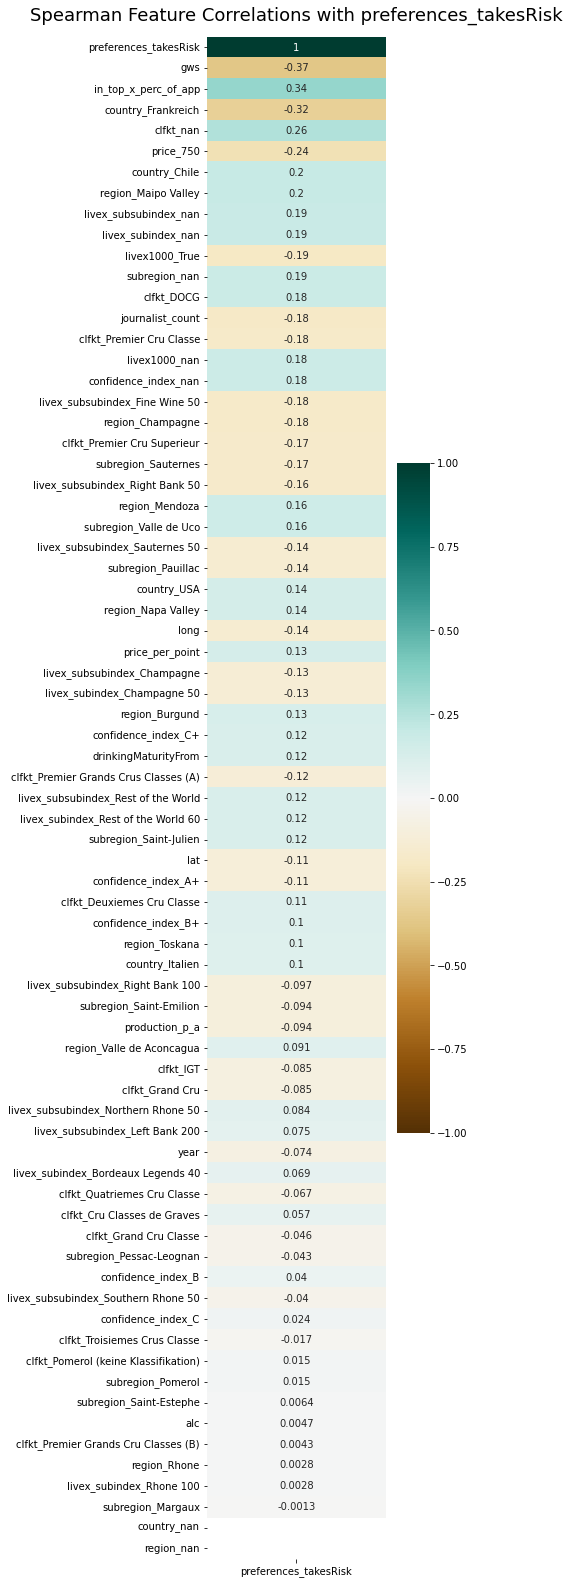

In [ ]:
X_norm_only = X


import seaborn as sns
import matplotlib.pyplot as plt

numerical_features = [
    "year",
    "drinkingMaturityFrom",
    "alc",
    "price_750",
    "production_p_a",
    "in_top_x_perc_of_app",
    "price_per_point",
    "gws",
    "lat",
    "long",
    "journalist_count"
]

target = 'preferences_takesRisk'

plot_data_labels_to_delete = ['preferences_investmentHorizon', 'preferences_takesRisk', 'preferences_wineloverVsInvestor']
plot_data_labels_to_delete.remove(target)


plt.figure(figsize=(4, 28))
heatmap = sns.heatmap(X_norm_only[X_norm_only.columns.difference(plot_data_labels_to_delete)].corr(method="spearman")[[target]].sort_values(by=target, key=abs, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title("Spearman Feature Correlations with {}".format(target), fontdict={'fontsize':18}, pad=16)
plt.savefig('{}_spearman_feature_label_correlation1.pdf'.format(target), bbox_inches='tight')

(174, 75)


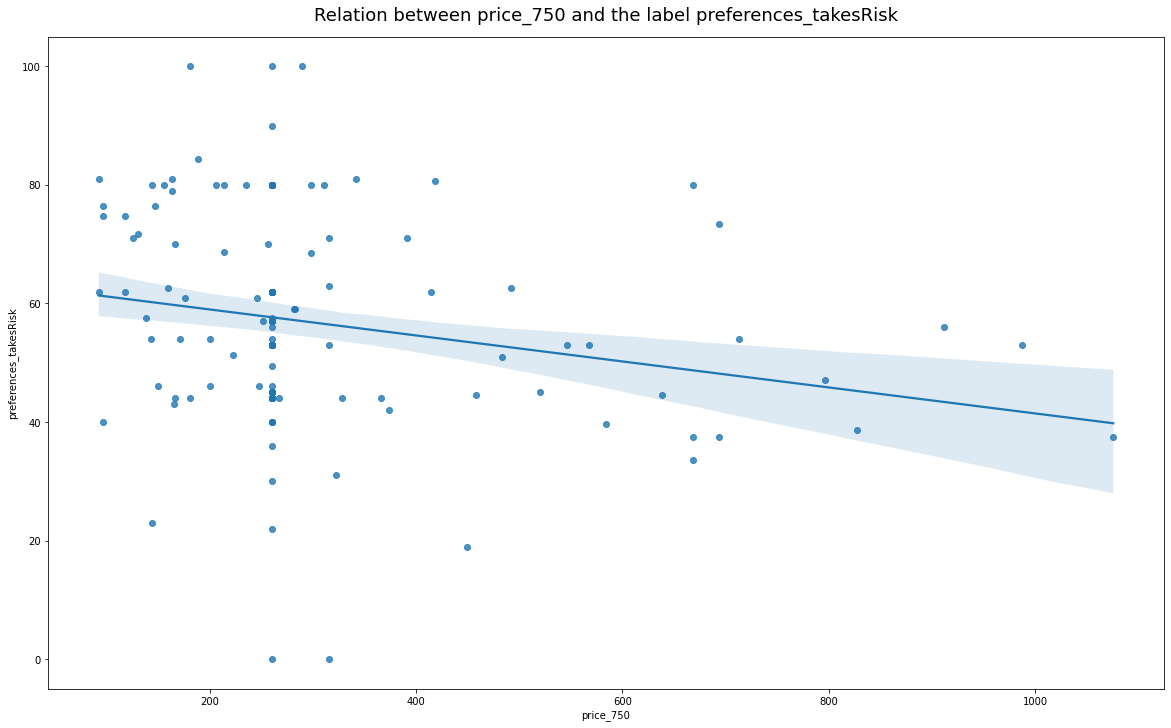

In [ ]:
plt.figure(figsize=(20, 12))
tgt = ['gws', "alc", 'price_750', "in_top_x_perc_of_app", "production_p_a", "year", "price_per_point", "lat"]
ind = 2
regplot = sns.regplot(data=X_norm_only, x=tgt[ind], y=target)
regplot.set_title("Relation between {} and the label {}".format(tgt[ind], target), fontdict={'fontsize':18}, pad=16)
plt.savefig('{}_{}_scatterplot1.pdf'.format(tgt[ind], target), bbox_inches='tight')
print(X_norm_only.shape)


'preferences_wineloverVsInvestor_norm'
name 'X_unlabled' is not defined
(174, 72)


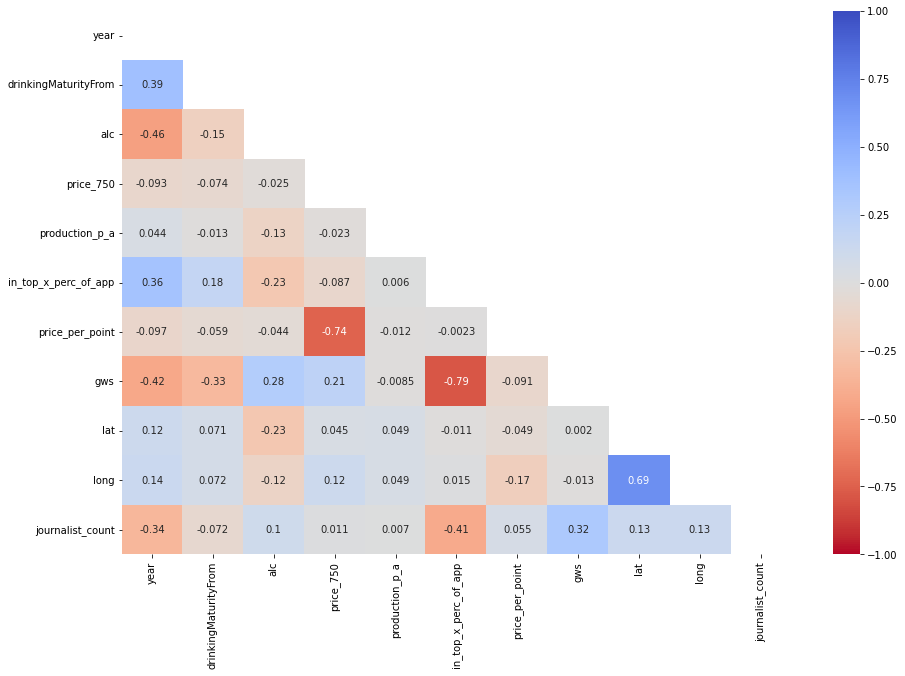

In [ ]:


try:
  #X_unlabled = X_norm_only[X_norm_only["preferences_takesRisk"].isnull()]
  #X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
  #del X_norm_only['preferences_wineloverVsInvestor']
  del X_norm_only['preferences_wineloverVsInvestor_norm']
  #del X_norm_only['preferences_takesRisk']
  del X_norm_only['preferences_takesRisk_norm']
  #del X_norm_only['preferences_investmentHorizon']
  del X_norm_only['preferences_investmentHorizon_norm']
except Exception as e:
  print(e)

try:
  #X_unlabled = X_norm_only[X_norm_only["preferences_takesRisk"].isnull()]
  #X_norm_only = X_norm_only[~X_norm_only["preferences_takesRisk"].isnull()]
  #del X_norm_only['preferences_wineloverVsInvestor']
  del X_unlabled['preferences_wineloverVsInvestor_norm']
  #del X_norm_only['preferences_takesRisk']
  del X_unlabled['preferences_takesRisk_norm']
  #del X_norm_only['preferences_investmentHorizon']
  del X_unlabled['preferences_investmentHorizon_norm']
except Exception as e:
  print(e)









try: 
  y_wvi = X_norm_only['preferences_wineloverVsInvestor']
  y_tr = X_norm_only['preferences_takesRisk']
  y_ih = X_norm_only['preferences_investmentHorizon']
  del X_norm_only['preferences_wineloverVsInvestor']
  del X_norm_only['preferences_takesRisk']
  del X_norm_only['preferences_investmentHorizon']
except Exception as e:
  print(e)

    
except:
    pass


#sns.heatmap(X_norm_only.corr())


plt.figure(figsize=(15, 10))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(X_norm_only[numerical_features].corr(), dtype=np.bool))
heatmap = sns.heatmap(X_norm_only[numerical_features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
#heatmap.set_title('Triangle absolute correlation heatmap of features', fontdict={'fontsize':23}, pad=20)
X_norm_only.columns
print(X_norm_only.shape)
plt.savefig('numberical_correlations_features.pdf', bbox_inches='tight')



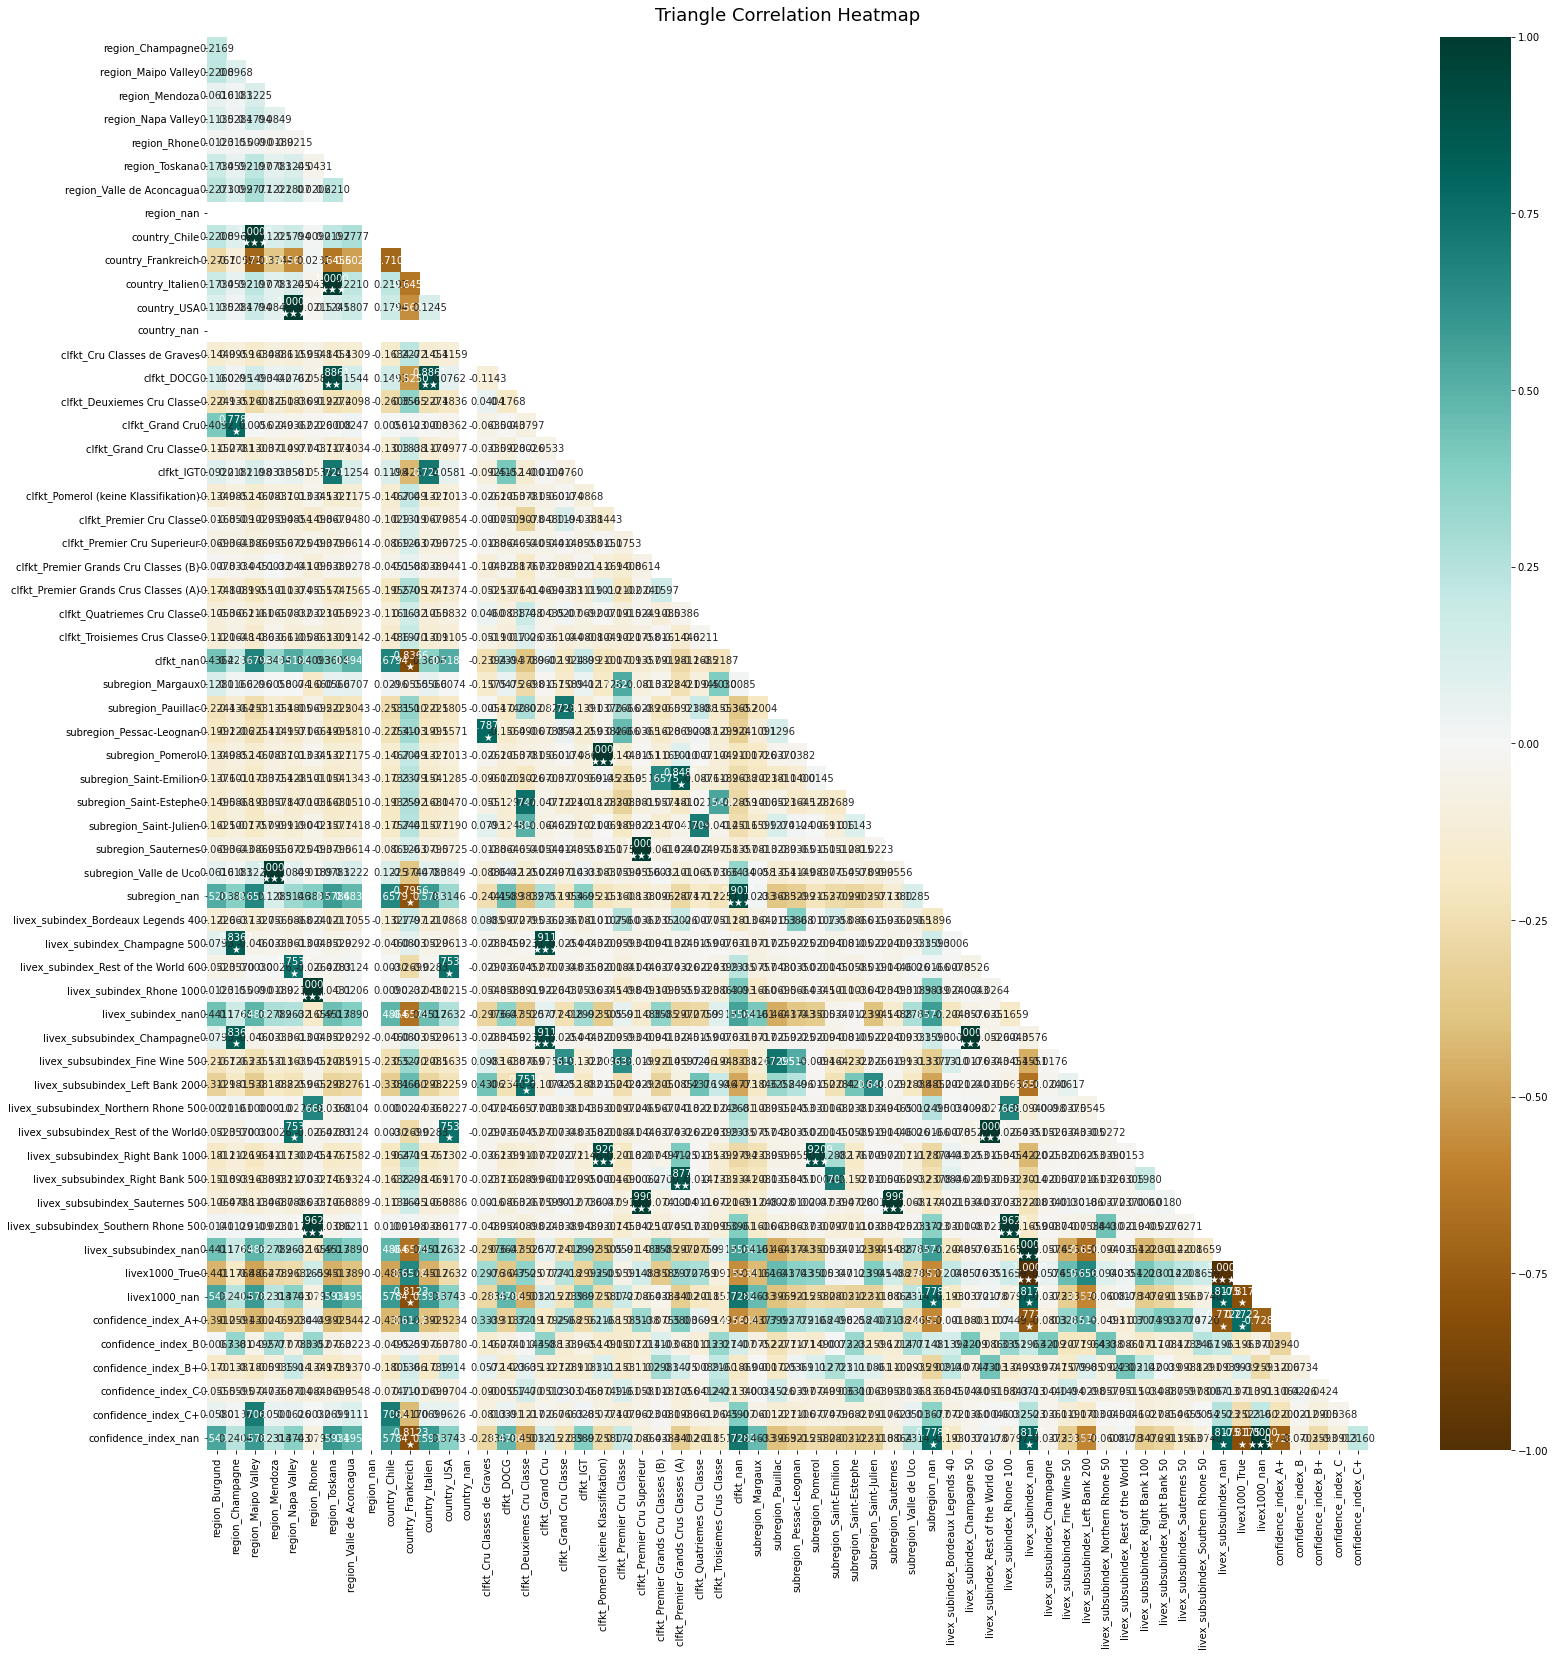

,year,drinkingMaturityFrom,alc,price_750,production_p_a,in_top_x_perc_of_app,price_per_point,gws,lat,long,journalist_count
lwin11,,,,,,,,,,,
10060452015,7,-3.0,15.0,260.50,10000,1.036415,0.372514,97.040000,-0.171677,44.892996,21.0
10832462019,3,-3.0,14.5,171.00,30000,6.474685,0.558825,95.558993,-70.590606,-33.618608,16.0
10097692020,2,-8.0,14.0,200.00,10000,0.756303,0.486500,97.300000,-0.192405,44.912832,13.0
10062052016,6,0.0,13.5,260.50,2000,0.196078,0.378042,98.480000,-0.156894,44.888818,19.0
10060452017,5,-3.0,14.0,373.95,10000,3.249300,0.254660,95.230000,-0.171677,44.892996,14.0
...,...,...,...,...,...,...,...,...,...,...,...
10118722011,11,2.0,12.5,260.50,20000,11.210317,0.361881,94.270000,-0.772436,45.224953,17.0
10112472013,9,-1.0,15.0,260.50,11000,12.871823,0.353781,92.160000,-0.608612,44.816652,20.0
10127812014,8,4.0,13.0,546.22,12500,6.474685,0.174946,95.558993,-0.668757,45.044430,16.0


In [ ]:

categorical_features = [ x for x in X_norm_only.columns if x not in numerical_features]

corr = X_norm_only[categorical_features].corr(method="spearman")


plt.figure(figsize=(26,26))
corr = corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cut_off = 0  # only show cells with abs(correlation) at least this value
extreme_1 = 0.75  # show with a star
extreme_2 = 0.85  # show with a second star
extreme_3 = 0.90  # show with a third star
mask |= np.abs(corr) < cut_off
corr = corr[~mask]  # fill in NaN in the non-desired cells

remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n★')  # add one star if abs(val) >= extreme_1
          + ('' if abs(val) < extreme_2 else '★')  # add an extra star if abs(val) >= extreme_2
          + ('' if abs(val) < extreme_3 else '★')  # add yet an extra star if abs(val) >= extreme_3
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)
plt.show()



# plt.figure(figsize=(15, 10))
# # define the mask to set the values in the upper triangle to True


# mask = np.triu(np.ones_like(X_norm_only[categorical_features].corr(method="spearman"), dtype=np.bool))
# heatmap = sns.heatmap(X_norm_only[categorical_features].corr(method="spearman"), mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True))
# #heatmap.set_title('Triangle absolute correlation heatmap of features', fontdict={'fontsize':23}, pad=20)
# X_norm_only.columns
# print(X_norm_only.shape)
# plt.savefig('categorical_correlations_features.pdf', bbox_inches='tight
X_norm_only[numerical_features]

In [ ]:
for l in norm_labels_1:
  try:
  
    del X_norm_only[l]
  except:
    pass

for l in norm_labels_2:
  try:
  
    del X_norm_only[l]
  except:
    pass

for l in norm_labels_1:
  try:
  
    del X_unlabled[l]
  except:
    pass

for l in norm_labels_2:
  try:
  
    del X_unlabled[l]
  except:
    pass


NameError: name 'norm_labels_1' is not defined

In [ ]:
X_std = X_norm_only.copy()
X_std[numerical_features] = StandardScaler().fit_transform(X_norm_only[numerical_features])
print(X_std)




                 year  drinkingMaturityFrom       alc  price_750  \
lwin11                                                             
10060452015 -0.308909             -0.337714  1.749571  -0.219100   
10832462019 -0.841089             -0.337714  1.064854  -0.788479   
10097692020 -0.974134             -0.447018  0.380136  -0.603987   
10062052016 -0.441954             -0.272131 -0.304581  -0.219100   
10060452017 -0.574999             -0.337714  0.380136   0.502643   
...               ...                   ...       ...        ...   
10118722011  0.223271             -0.228409 -1.674016  -0.219100   
10112472013 -0.042819             -0.293992  1.749571  -0.219100   
10127812014 -0.175864             -0.184687 -0.989299   1.598586   
10087462016 -0.441954             -0.359574 -0.304581  -0.219100   
10118722018 -0.708044             -0.447018 -0.578468   4.966572   

             production_p_a  in_top_x_perc_of_app           gws  \
lwin11                                          

In [ ]:

# Train test split for WineloverVsInvestor label
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
#import neptune.new as neptune
import neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import neptunecontrib.monitoring.kerastuner as npt_utils 

# run = neptune.init(
#     project_qualified_name="martin.dammrath/BCRecSys",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2MWY3OWE1NS02ZDdhLTQ1ZmEtYTQxMS03NTNmNGIyYTQzNWIifQ==",
# )

# neptune.create_experiment('tuner-sweep')

# lreg = Ridge(alpha=1)
# tree = DecisionTreeRegressor(random_state=0)

# PREDICT RISK

from keras.losses import mean_squared_error

def root_mean_squared_error_loss(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.losses.MSE(y_true, y_pred))


def tune_model(y, npt_exp_str):
  # neptune.create_experiment(npt_exp_str)
  X_train, X_rem, y_train, y_rem = train_test_split(np.asarray(X_std).astype(np.float32), y, test_size=0.3, random_state=3)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.4, random_state=3)
  print(y_train.shape, y_test.shape, y_valid.shape)
  def build_model(hp):
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-1, sampling="log")
    #batch_size = hp.Int("bs",  min_value=2, max_value=10, step=1)
    model = keras.Sequential()
    model.add(keras.layers.Dense(72, activation='relu'))
    for i in range(hp.Int("n_layers", 1, 6)):
      model.add(keras.layers.Dense(
      units = hp.Int(f"units_{i}", min_value=5, max_value=120, step=5),
      activation=hp.Choice(f"act_{i}", ["relu", "tanh"])))
      if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=(hp.Float(f"do_{i}", min_value = 0.2, max_value = 0.8, step=0.2))))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate),  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(X_train,y_train, epochs=1)
    return model

  # Root mean squared error
  


  # Better try different ones here like Bayesian Optimization
  tuner = kt.RandomSearch(
      hypermodel=build_model,
      objective='val_loss',
      max_trials=10,
      executions_per_trial=2,
      overwrite=True,
      seed=5,
      project_name='tuner-sweep',
      directory="./"
      )

  tuner.search_space_summary()

  tuner.search(x=X_train,
              y=y_train,
              epochs=200,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100), ],
              batch_size=5,
              validation_data=(X_valid, y_valid),
              verbose=True)

  # npt_utils.log_tuner_info(tuner)

  tuner.results_summary()

  # neptune.stop()

  models = tuner.get_best_models(num_models=2)
  best_model = models[0]
  best_model.build(input_shape=X_train.shape)
  print(best_model.summary())

  return best_model

fnn_tr = tune_model(y_tr, "takes_risk_tuning")
fnn_ih = tune_model(y_ih, "invest_horizon_tuning")
fnn_wvi = tune_model(y_wvi, "winelover_vs_invest_tuning")

#run.stop()


Trial 10 Complete [00h 00m 28s]
val_loss: 1289.6205444335938

Best val_loss So Far: 550.361328125
Total elapsed time: 00h 04m 27s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./tuner-sweep
Showing 10 best trials
Trial summary
Hyperparameters:
lr: 0.006951671294413008
n_layers: 6
units_0: 70
act_0: relu
dropout: False
units_1: 25
act_1: tanh
units_2: 50
act_2: relu
units_3: 70
act_3: relu
units_4: 120
act_4: relu
do_0: 0.8
do_1: 0.6000000000000001
do_2: 0.4
do_3: 0.2
do_4: 0.4
units_5: 110
act_5: relu
do_5: 0.4
Score: 550.361328125
Trial summary
Hyperparameters:
lr: 0.017611785596585997
n_layers: 5
units_0: 40
act_0: relu
dropout: False
units_1: 5
act_1: relu
units_2: 5
act_2: relu
units_3: 5
act_3: relu
units_4: 5
act_4: relu
Score: 634.2817077636719
Trial summary
Hyperparameters:
lr: 0.0011510936029076842
n_layers: 2
units_0: 110
act_0: tanh
dropout: True
units_1: 85
act_1: tanh
units_2: 65
act_2: relu
units_3: 65
act_3: relu
units_4: 115
act_4: relu
do_0: 0.600000

In [ ]:

from sklearn.metrics import mean_squared_error
from math import sqrt

def calculate_rmse_for_model(fnn, y):
    X_train, X_rem, y_train, y_rem = train_test_split(np.asarray(X_std).astype(np.float32), y, test_size=0.2, random_state=3)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=3)
    
    print(fnn.summary())
    K = tf.keras.backend

    def root_mean_squared_error(y_true, y_pred):
            return sqrt(mean_squared_error(list(y_pred),list(y_true)))
    print("rmse val: ", root_mean_squared_error(y_valid.values,fnn.predict(X_valid)))
    print("rmse test: ", root_mean_squared_error(y_test.values,fnn.predict(X_test)))
            
    return 0

print("----- TAKES RISK -----")
calculate_rmse_for_model(fnn_tr, y_tr)

print("----- INVESTMENT HORIZON -----")
calculate_rmse_for_model(fnn_ih, y_ih)
print("----- WVI -----")
calculate_rmse_for_model(fnn_wvi, y_wvi)

----- TAKES RISK -----
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 72)                5256      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3650      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 105)               5355      
_________________________________________________________________
dropout_2 (Dropout)          (Non

0

In [ ]:
X_norm_only


,year,drinkingMaturityFrom,alc,price_750,production_p_a,in_top_x_perc_of_app,gws,journalist_count,price_per_point,lat,...,livex_subsubindex_Southern Rhone 50,livex_subsubindex_nan,livex1000_True,livex1000_nan,confidence_index_A+,confidence_index_B,confidence_index_B+,confidence_index_C,confidence_index_C+,confidence_index_nan
lwin11,,,,,,,,,,,,,,,,,,,,,
10060452015,7,-3.0,15.0,260.50,10000,1.036415,97.040000,21.0,0.372514,-0.171677,...,0,0,1,0,1,0,0,0,0,0
10832462019,3,-3.0,14.5,171.00,30000,6.474685,95.558993,16.0,0.558825,-70.590606,...,0,1,0,1,0,0,0,0,0,1
10097692020,2,-8.0,14.0,200.00,10000,0.756303,97.300000,13.0,0.486500,-0.192405,...,0,1,0,0,1,0,0,0,0,0
10062052016,6,0.0,13.5,260.50,2000,0.196078,98.480000,19.0,0.378042,-0.156894,...,0,0,1,0,1,0,0,0,0,0
10060452017,5,-3.0,14.0,373.95,10000,3.249300,95.230000,14.0,0.254660,-0.171677,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10118722011,11,2.0,12.5,260.50,20000,11.210317,94.270000,17.0,0.361881,-0.772436,...,0,0,1,0,1,0,0,0,0,0
10112472013,9,-1.0,15.0,260.50,11000,12.871823,92.160000,20.0,0.353781,-0.608612,...,0,0,1,0,0,0,0,0,0,0
10127812014,8,4.0,13.0,546.22,12500,6.474685,95.558993,16.0,0.174946,-0.668757,...,0,1,0,1,0,0,0,0,0,1


In [ ]:


#print(lreg.predict(X_train), y_train)
# for x in zip(lreg.coef_,X_train.columns):
#     print("{}: {}".format(x[1], x[0]))

# DALEX
# BREAK DOWN

import dalex as dx
X_transf = np.asarray(X_std).astype(np.float32)
#surrogate = dx.Explainer.model_surrogate()
exp_tr = dx.Explainer(fnn_tr, X_std, y_tr, label="y_tr")
exp_wvi = dx.Explainer(fnn_wvi, X_std, y_tr, label="y_wvi")
exp_ih = dx.Explainer(fnn_ih, X_std, y_tr, label="y_ih")
#exp.predict(X_transf)[0:10]
#X[:1]

observation_no = 12
sample = X_transf[observation_no - 1:observation_no]
#print(X_norm_only[observation_no - 1:observation_no].index)



Preparation of a new explainer is initiated

  -> data              : 174 rows 72 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 174 values
  -> model_class       : keras.engine.sequential.Sequential (default)
  -> label             : y_tr
  -> predict function  : <function yhat_tf_regression at 0x7fead8232ee0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 55.9, max = 60.1
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -29.0, mean = 0.977, max = 44.0
  -> model_info        : package keras

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 174 rows 72 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   :

In [ ]:


bd = exp_ih.predict_parts(X_std[7:8], type='break_down', label="Exp")


labels = []

for x in bd.result.variable_name:
    try:
        labels.append(X_norm_only.columns[int(x)])
    except:
        labels.append(x)
        
bd.result.variable_name=labels
#bd.result.variable_name = labels
#bd.result.set_index(bd.result.variable_name, inplace=True)
res = pd.concat([bd.result[1:5], bd.result[-5:]])
#exp.model_parts().plot()
print(bd.result)

res
bd.plot(max_vars=72)





                           variable_name variable_value  \
0                              intercept              1   
1                                    alc          1.065   
2                                    gws         0.6828   
3                     subregion_Pauillac            1.0   
4                        price_per_point         0.9001   
..                                   ...            ...   
69  clfkt_Premier Grands Cru Classes (B)            0.0   
70                   confidence_index_B+            0.0   
71            clfkt_Deuxiemes Cru Classe            1.0   
72                                  year         -0.708   
73                                                        

                                      variable  cumulative  contribution  \
0                                    intercept    9.638405      9.638405   
1                                  alc = 1.065   10.820333      1.181929   
2                                 gws = 0.6828   11.803550     

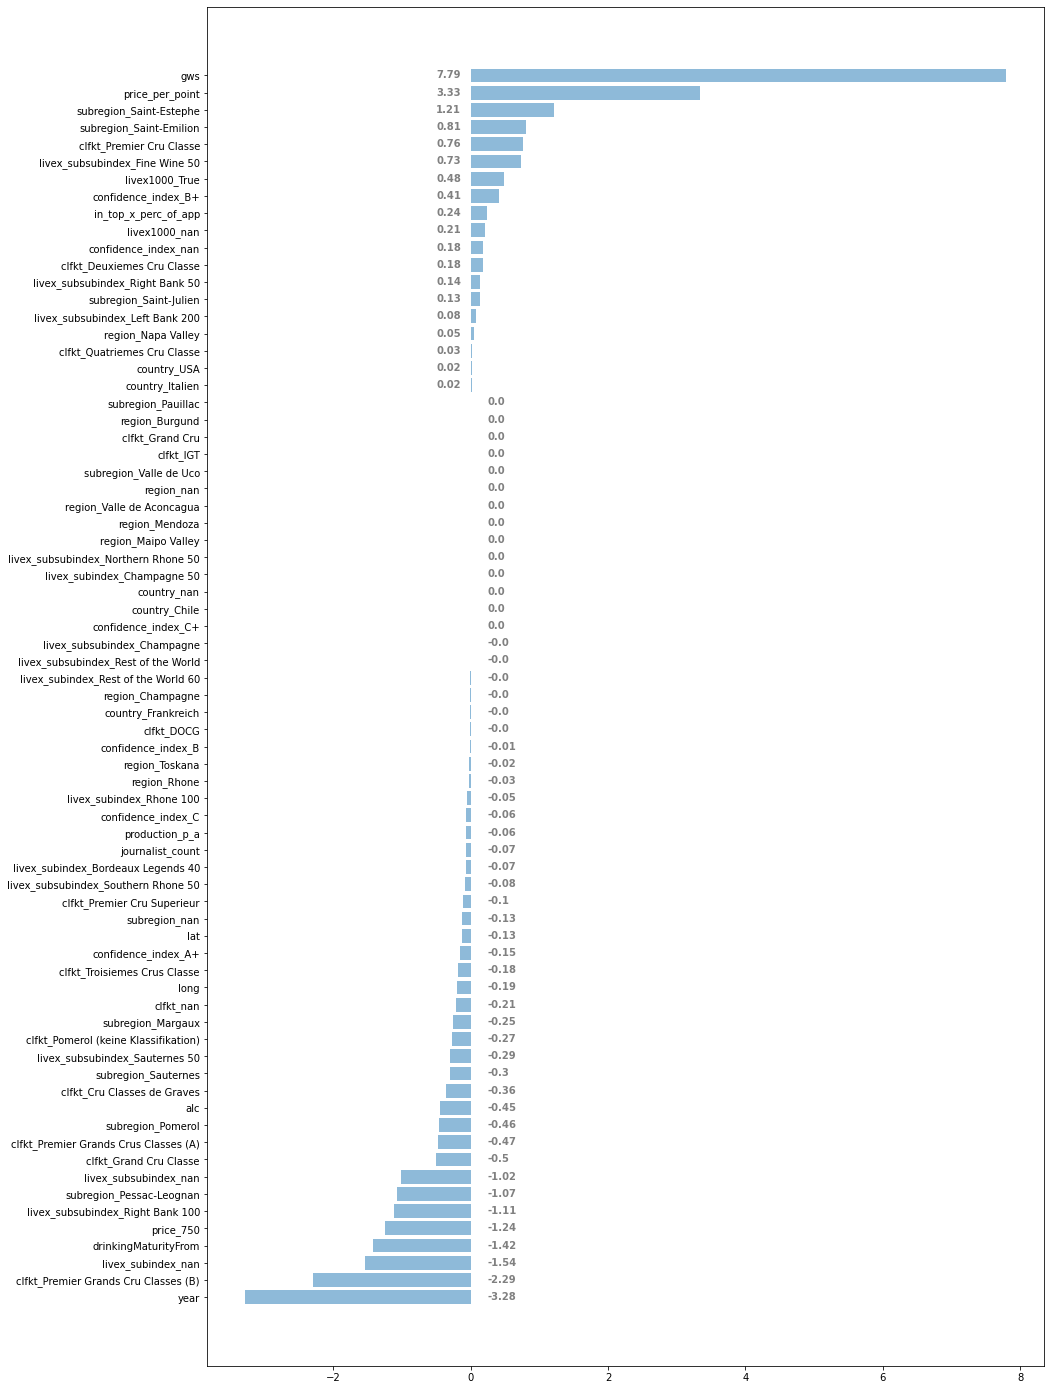

In [ ]:
import random
fig, ax = plt.subplots(figsize=(15,25)) 

zpd = sorted(zip(bd.result.contribution[1:-1], labels[1:-1]))
plt.barh([x for _,x in (zpd)], [x for x,_ in (zpd)], align='center', alpha=0.5)
#plt.bar_label( [x for x,_ in (zpd)])

for i, v in enumerate( [round(x,2) for x,_ in (zpd)]):     
    if v > 0:
        z = -0.5
    else:
        z = 0.25
    ax.text(z, i - 0.15 , str(v), color='grey', fontweight='bold')


#plt.savefig('contribution_{}_tr.pdf'.format(str(random.randint(0, 1000))), bbox_inches='tight')






In [ ]:
from keras.utils.vis_utils import plot_model
#plot_model(fnn_tr, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
fnn_wvi.summary()
for i, layer in enumerate (fnn_wvi.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 72)                5256      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3650      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 8,957
Trainable params: 8,957
Non-trainable params: 0
_________________________________________________________________
0 <keras.layers.core.Dense object at 0x7f1a8bd1bcd0>
     <function relu at 0x7f1a39b2cdc0>
1 <keras.layers.core.Dense object at 0x7f196707e280>
     <function tanh at 0x7f1a39b30040>
2 <keras.layers.core.Dense object at 0x7f196707e3d0>
     <function relu at 0x7f1a39b2cdc0>


In [ ]:
pred_tr = fnn_tr.predict(X_unlabled)
pred_wvi = fnn_wvi.predict(X_unlabled)
pred_ih = fnn_ih.predict(X_unlabled)

X_unlabled_transf = np.asarray(X_unlabled).astype(np.float32)

expl_tr = []
expl_wvi = []
expl_ih = []

for sample in X_unlabled_transf:
    expl = exp_tr.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_tr.append([expl[k] for k in expl.keys()])

    expl = exp_wvi.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_wvi.append([expl[k] for k in expl.keys()])

    expl = exp_ih.predict_parts(sample, type='break_down', label="bd")
    expl.result.variable_name = labels
    expl = pd.concat([expl.result[1:3], expl.result[-3:-1]])
    expl = expl.transpose().to_dict()
    expl_ih.append([expl[k] for k in expl.keys()])

tp = res.transpose().to_dict()
r = [tp[k] for k in tp.keys()]


Unexpected error in ping thread.
Traceback (most recent call last):
  File "/home/martin/.local/share/virtualenvs/recsys-yrG1R0OC/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/home/martin/.local/share/virtualenvs/recsys-yrG1R0OC/lib/python3.8/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/martin/.local/share/virtualenvs/recsys-yrG1R0OC/lib/python3.8/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.8/http/client.py", line 1348, in getresponse
    response.begin()
  File "/usr/lib/python3.8/http/client.py", line 316, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.8/http/client.py", line 277, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/l

In [ ]:
mdl = fnn_wvi
print(mdl.summary())
for i, layer in enumerate (mdl.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1770      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 2,731
Trainable params: 2,731
Non-trainable params: 0
_________________________________________________________________
None
0 <keras.layers.core.Dense object at 0x7f199d5384f0>
     <function tanh at 0x7f1a39b30040>
1 <keras.layers.core.Dense object at 0x7f1a7e523fd0>
     <function tanh at 0x7f1a39b30040>
2 <keras.layers.core.Dense object at 0x7f1b646b40d0>
     <function relu at 0x7f1a39b2cdc0>


In [ ]:
result_json = []
for s in list(zip(pred_tr, expl_tr, pred_wvi, expl_wvi, pred_ih, expl_ih)):
    result_json.append(
        {
        "takes_risk_prediction": s[0][0],
        "takes_risk_breakdown": s[1],
        "winelover_vs_investor_prediction": s[2][0],
        "winelover_vs_investor_breakdown": s[3],
        "investment_horizon_prediction": s[4][0],
        "investment_horizon_breakdown": s[5],
        }
    )

result_json[0]

{'takes_risk_prediction': 65.33896,
 'takes_risk_breakdown': [{'variable_name': 'livex1000_nan',
   'variable_value': '166.0',
   'variable': '1 = 166.0',
   'cumulative': 61.45513916015625,
   'contribution': 7.528099060058594,
   'sign': 1.0,
   'position': 58,
   'label': 'bd'},
  {'variable_name': 'livex_subindex_nan',
   'variable_value': '1.0',
   'variable': '30 = 1.0',
   'cumulative': 64.3703384399414,
   'contribution': 2.9151992797851562,
   'sign': 1.0,
   'position': 57,
   'label': 'bd'},
  {'variable_name': 'clfkt_Premier Cru Classe',
   'variable_value': '0.0',
   'variable': '19 = 0.0',
   'cumulative': 68.47184753417969,
   'contribution': -0.430572509765625,
   'sign': -1.0,
   'position': 2,
   'label': 'bd'},
  {'variable_name': 'price_750',
   'variable_value': '1.0',
   'variable': '4 = 1.0',
   'cumulative': 65.3389663696289,
   'contribution': -3.1328811645507812,
   'sign': -1.0,
   'position': 1,
   'label': 'bd'}],
 'winelover_vs_investor_prediction': 52.243

In [ ]:
import json
lwins = X_unlabled.index.values
i = 0
for sample in result_json:
    sample["lwin_11"] = str(lwins[i])
    sample["takes_risk_prediction"] = float(sample["takes_risk_prediction"])
    sample["winelover_vs_investor_prediction"] = float(sample["winelover_vs_investor_prediction"])
    sample["investment_horizon_prediction"] = float(sample["investment_horizon_prediction"])
    i += 1
    print(i)
#json_string = json.dumps(result_json)
with open('model_results.json', 'w') as outfile:
    json.dump(result_json, outfile)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


In [ ]:
type(result_json[0]['takes_risk_prediction'])

In [ ]:

f = open("model_results.json")
im = json.load(f)
im

In [ ]:
print(result_json)
X_unlabled.shape


[{'takes_risk_prediction': 65.33895874023438, 'takes_risk_breakdown': [{'variable_name': 'livex1000_nan', 'variable_value': '166.0', 'variable': '1 = 166.0', 'cumulative': 61.45513916015625, 'contribution': 7.528099060058594, 'sign': 1.0, 'position': 58, 'label': 'bd'}, {'variable_name': 'livex_subindex_nan', 'variable_value': '1.0', 'variable': '30 = 1.0', 'cumulative': 64.3703384399414, 'contribution': 2.9151992797851562, 'sign': 1.0, 'position': 57, 'label': 'bd'}, {'variable_name': 'clfkt_Premier Cru Classe', 'variable_value': '0.0', 'variable': '19 = 0.0', 'cumulative': 68.47184753417969, 'contribution': -0.430572509765625, 'sign': -1.0, 'position': 2, 'label': 'bd'}, {'variable_name': 'price_750', 'variable_value': '1.0', 'variable': '4 = 1.0', 'cumulative': 65.3389663696289, 'contribution': -3.1328811645507812, 'sign': -1.0, 'position': 1, 'label': 'bd'}], 'winelover_vs_investor_prediction': 52.243892669677734, 'winelover_vs_investor_breakdown': [{'variable_name': 'livex1000_nan

(173, 58)